# ResNet50图像分类

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r1.8/tutorials/application/zh_cn/cv/mindspore_resnet50.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r1.8/tutorials/application/zh_cn/cv/mindspore_resnet50.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/r1.8/tutorials/application/source_zh_cn/cv/resnet50.ipynb)

图像分类是最基础的计算机视觉应用，属于有监督学习类别，如给定一张图像(猫、狗、飞机、汽车等等)，判断图像所属的类别。本章将介绍使用ResNet50网络对CIFAR-10数据集进行分类。

## ResNet网络介绍

ResNet50网络是2015年由微软实验室的何恺明提出，获得ILSVRC2015图像分类竞赛第一名。在ResNet网络提出之前，传统的卷积神经网络都是将一系列的卷积层和池化层堆叠得到的，但当网络堆叠到一定深度时，就会出现退化问题。下图是在CIFAR-10数据集上使用56层网络与20层网络训练误差和测试误差图，由图中数据可以看出，56层网络比20层网络训练误差和测试误差更大，随着网络的加深，其误差并没有如预想的一样减小。

![resnet-1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/resnet_1.png)

ResNet网络提出了残差网络结构(Residual Network)来减轻退化问题，使用ResNet网络可以实现搭建较深的网络结构（突破1000层）。论文中使用ResNet网络在CIFAR-10数据集上的训练误差与测试误差图如下图所示，图中虚线表示训练误差，实线表示测试误差。由图中数据可以看出，ResNet网络层数越深，其训练误差和测试误差越小。

![resnet-4](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/resnet_4.png)

> 了解ResNet网络更多详细内容，参见[ResNet论文](https://arxiv.org/pdf/1512.03385.pdf)。

## 数据集准备与加载

[CIFAR-10数据集](http://www.cs.toronto.edu/~kriz/cifar.html)共有60000张32*32的彩色图像，分为10个类别，每类有6000张图，数据集一共有50000张训练图片和10000张评估图片。如下示例使用`mindspore.dataset`接口下载并加载CIFAR-10数据集。

首先将数据集下载到指定目录下并解压，目前仅支持解析二进制版本的CIFAR-10文件（CIFAR-10 binary version）
    
下载后的数据集目录结构如下：

```Text
datasets-cifar10-bin/cifar-10-batches-bin
├── batches.meta.text
├── data_batch_1.bin
├── data_batch_2.bin
├── data_batch_3.bin
├── data_batch_4.bin
├── data_batch_5.bin
├── readme.html
└── test_batch.bin

```

In [41]:
from download import download

url = "http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz"

path = download(url, "./datasets-cifar10-bin", kind="tar.gz")


file_sizes: 100%|████████████████████████████| 170M/170M [01:20<00:00, 2.10MB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./datasets-cifar10-binary


In [47]:
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
import mindspore 

from mindspore import nn, ops


data_dir = "./datasets-cifar10-bin/cifar-10-batches-bin" # 数据集根目录
batch_size = 6 # 批量大小
image_size = 32 # 训练图像空间大小
workers = 4 # 并行线程个数
num_classes = 10 # 分类数量

def create_dataset_cifar10(dataset_dir, usage, resize, batch_size, workers):

    data_set = ds.Cifar10Dataset(dataset_dir=dataset_dir, 
                                usage=usage, 
                                num_parallel_workers=workers, 
                                shuffle=True)


    trans = []
    if usage == "train":
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    
    trans += [
        vision.Resize(resize),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]
    
    # target_trans = [
    #     transforms.OneHot(num_classes=num_classes)
    # ]

    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)

    # data_set = data_set.map(
    #     operations=target_trans,
    #     input_columns='label',
    #     num_parallel_workers=workers
    # )
    
    # 批量操作
    data_set = data_set.batch(batch_size)


    return data_set
    

# 获取处理后的训练与测试数据集

dataset_train = create_dataset_cifar10(dataset_dir=data_dir,
                                        usage="train",
                                        resize=image_size,
                                        batch_size=batch_size,
                                        workers=workers)
step_size_train = dataset_train.get_dataset_size()
index_label_dict = dataset_train.get_class_indexing()

dataset_val = create_dataset_cifar10(dataset_dir=data_dir,
                                        usage="test",
                                        resize=image_size,
                                        batch_size=batch_size,
                                        workers=workers)
step_size_val = dataset_val.get_dataset_size()
print(step_size_train)
print(step_size_val)


8334
1667



对处理后的CIFAR-10训练数据集进行可视化。

Image shape: (6, 3, 32, 32), Label: [3 4 0 1 1 6]


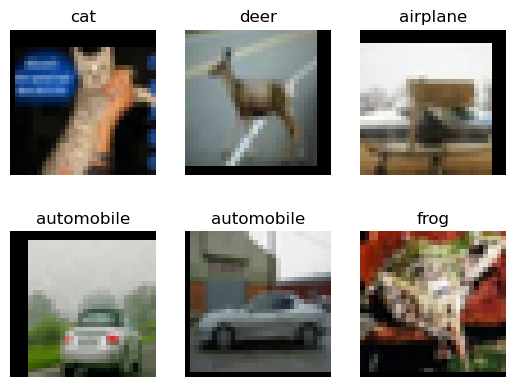

In [48]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
# labels = data_iter["label"].asnumpy().argmax(axis=1)
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label: {labels}")

classes = []

with open(data_dir+"/batches.meta.txt", "r") as f:
    for line in f:
        line = line.rstrip()
        if line != '':
            classes.append(line)

plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{classes[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()


## 构建网络

残差网络结构(Residual Network)是ResNet网络的主要亮点，ResNet使用残差网络结构后可有效地减轻退化问题，实现更深的网络结构设计，提高网络的训练精度。本节首先讲述如何构建残差网络结构，然后通过堆叠残差网络来构建ResNet50网络。

### 构建残差网络结构

残差网络结构图如下图所示，残差网络由两个分支构成：一个主分支，一个shortcuts（图中弧线表示）。主分支通过堆叠一系列的卷积操作得到，shotcuts从输入直接到输出，主分支输出的特征矩阵$F(x)$加上shortcuts输出的特征矩阵$x$得到$F(x)+x$，通过Relu激活函数后即为残差网络最后的输出。

![residual](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/resnet_3.png)

残差网络结构主要由两种，一种是Building Block，适用于较浅的ResNet网络，如ResNet18和ResNet34；另一种是Bottleneck，适用于层数较深的ResNet网络，如ResNet50、ResNet101和ResNet152。

#### Building Block

Building Block结构图如下图所示，主分支有两层卷积网络结构：

+ 主分支第一层网络以输入channel为64为例，首先通过一个$3\times3$的卷积层，然后通过Batch Normalization层，最后通过Relu激活函数层，输出channel为64；
+ 主分支第二层网络的输入channel为64，首先通过一个$3\times3$的卷积层，然后通过Batch Normalization层，输出channel为64。

最后将主分支输出的特征矩阵与shortcuts输出的特征矩阵相加，通过Relu激活函数即为Building Block最后的输出。

![building-block-5](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/resnet_5.png)

主分支与shortcuts输出的特征矩阵相加时，需要保证主分支与shortcuts输出的特征矩阵shape相同。如果主分支与shortcuts输出的特征矩阵shape不相同，如输出channel是输入channel的一倍时，shortcuts上需要使用数量与输出channel相等，大小为$1\times1$的卷积核进行卷积操作；若输出的图像较输入图像缩小一倍，则要设置shortcuts中卷积操作中的`stride`为2，主分支第一层卷积操作的`stride`也需设置为2。

如下代码定义`ResidualBlockBase`类实现Building Block结构。

In [49]:
from typing import Type, Union, List, Optional
from mindspore import nn
from mindspore.common.initializer import Normal

weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)

class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # 最后一个卷积核数量与第一个卷积核数量相等

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d(out_channel)
        else:
            self.norm = norm
            
        self.conv1 = nn.Conv2d(in_channel, out_channel,
                              kernel_size=3, stride=stride,
                              weight_init=weight_init)
        self.conv2 = nn.Conv2d(in_channel, out_channel,
                              kernel_size=3, weight_init=weight_init)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcuts分支

        out = self.conv1(x)  # 主分支第一层：3*3卷积层
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm(out)
            
        if self.down_sample is not None:
            identity = self.down_sample(x)
        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out


#### Bottleneck

Bottleneck结构图如下图所示，在输入相同的情况下Bottleneck结构相对Building Block结构的参数数量更少，更适合层数较深的网络，ResNet50使用的残差结构就是Bottleneck。该结构的主分支有三层卷积结构，分别为$1\times1$的卷积层、$3\times3$卷积层和$1\times1$的卷积层，其中$1\times1$的卷积层分别起降维和升维的作用。

+ 主分支第一层网络以输入channel为256为例，首先通过数量为64，大小为$1\times1$的卷积核进行降维，然后通过Batch Normalization层，最后通过Relu激活函数层，其输出channel为64；
+ 主分支第二层网络通过数量为64，大小为$3\times3$的卷积核提取特征，然后通过Batch Normalization层，最后通过Relu激活函数层，其输出channel为64；
+ 主分支第三层通过数量为256，大小$1\times1$的卷积核进行升维，然后通过Batch Normalization层，其输出channel为256。

最后将主分支输出的特征矩阵与shortcuts输出的特征矩阵相加，通过Relu激活函数即为Bottleneck最后的输出。

![building-block-6](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/resnet_6.png)

主分支与shortcuts输出的特征矩阵相加时，需要保证主分支与shortcuts输出的特征矩阵shape相同。如果主分支与shortcuts输出的特征矩阵shape不相同，如输出channel是输入channel的一倍时，shortcuts上需要使用数量与输出channel相等，大小为$1\times1$的卷积核进行卷积操作；若输出的图像较输入图像缩小一倍，则要设置shortcuts中卷积操作中的`stride`为2，主分支第二层卷积操作的`stride`也需设置为2。

如下代码定义`ResidualBlock`类实现Bottleneck结构。

In [50]:
class ResidualBlock(nn.Cell):
    expansion = 4  # 最后一个卷积核的数量是第一个卷积核数量的4倍

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channel, out_channel, 
                               kernel_size=1, weight_init=weight_init)
        self.norm1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, 
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.norm2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, out_channel * self.expansion, 
                               kernel_size=1, weight_init=weight_init)
        self.norm3 = nn.BatchNorm2d(out_channel * self.expansion)

        self.relu = nn.ReLU()
        self.down_sample = down_sample 

    def construct(self, x):

        identity = x  # shortscuts分支

        out = self.conv1(x)  # 主分支第一层：1*1卷积层
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)  # 主分支第三层：1*1卷积层
        out = self.norm3(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)

        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

#### 构建ResNet50网络

ResNet网络层结构如下图所示，以输入彩色图像$224\times224$为例，首先通过数量64，卷积核大小为$7\times7$，stride为2的卷积层conv1，该层输出图片大小为$112\times112$，输出channel为64；然后通过一个$3\times3$的最大下采样池化层，该层输出图片大小为$56\times56$，输出channel为64；再堆叠4个残差网络块（conv2_x、conv3_x、conv4_x和conv5_x），此时输出图片大小为$7\times7$，输出channel为2048；最后通过一个平均池化层、全连接层和softmax，得到分类概率。

![resnet-layer](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/resnet_2.png)

对于每个残差网络块，以ResNet50网络中的conv2_x为例，其由3个Bottleneck结构堆叠而成，每个Bottleneck输入的channel为64，输出channel为256。

如下示例定义`make_layer`实现残差块的构建，其参数如下所示:

+ `last_out_channel`：上一个残差网络输出的通道数。
+ `block`：残差网络的类别，分别为`ResidualBlockBase`和`ResidualBlock`。
+ `channel`：残差网络输入的通道数。
+ `block_nums`：残差网络块堆叠的个数。
+ `stride`：卷积移动的步幅。

In [51]:
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts分支

    
    if stride != 1 or last_out_channel != channel * block.expansion:
        
        down_sample = nn.SequentialCell([
            nn.Conv2d(last_out_channel, channel * block.expansion,
                               kernel_size=1, stride=stride, weight_init=weight_init),
            nn.BatchNorm2d(channel * block.expansion, gamma_init=gamma_init)
        ])

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample))

    in_channel = channel * block.expansion
    # 堆叠残差网络
    for _ in range(1, block_nums):
        # print("input_channel:", in_channel)
        # print("output_channel:", channel)
        layers.append(block(in_channel, channel))

    return nn.SequentialCell(layers)

ResNet50网络共有5个卷积结构，一个平均池化层，一个全连接层，以CIFAR-10数据集为例：

+ **conv1**：输入图片大小为$32\times32$，输入channel为3。首先经过一个卷积核数量为64，卷积核大小为$7\times7$，stride为2的卷积层；然后通过一个Batch Normalization层；最后通过Reul激活函数。该层输出feature map大小为$16\times16$，输出channel为64。
+ **conv2_x**：输入feature map大小为$16\times16$，输入channel为64。首先经过一个卷积核大小为$3\times3$，stride为2的最大下采样池化操作；然后堆叠3个$[1\times1，64；3\times3，64；1\times1，256]$结构的Bottleneck。该层输出feature map大小为$8\times8$，输出channel为256。
+ **conv3_x**：输入feature map大小为$8\times8$，输入channel为256。该层堆叠4个[1×1，128；3×3，128；1×1，512]结构的Bottleneck。该层输出feature map大小为$4\times4$，输出channel为512。
+ **conv4_x**：输入feature map大小为$4\times4$，输入channel为512。该层堆叠6个[1×1，256；3×3，256；1×1，1024]结构的Bottleneck。该层输出feature map大小为$2\times2$，输出channel为1024。
+ **conv5_x**：输入feature map大小为$2\times2$，输入channel为1024。该层堆叠3个[1×1，512；3×3，512；1×1，2048]结构的Bottleneck。该层输出feature map大小为$1\times1$，输出channel为2048。
+ **average pool & fc**：输入channel为2048，输出channel为分类的类别数。

如下示例代码实现ResNet50模型的构建，通过用调函数`resnet50`即可构建ResNet50模型，函数`resnet50`参数如下：

+ `num_classes`：分类的类别数，默认类别数为1000。
+ `pretrained`：下载对应的训练模型，并加载预训练模型中的参数到网络中。

In [67]:
from mindspore import load_checkpoint, load_param_into_net


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], num_classes: int, input_channel: int) -> None:
        super(ResNet, self).__init__()

        self.relu = nn.ReLU()
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, weight_init=weight_init)
        self.norm = nn.BatchNorm2d(64)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义，
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)
        # 平均池化层
        self.avg_pool = nn.AvgPool2d()
        # flattern层
        self.flatten = nn.Flatten()
        # 全连接层
        self.fc = nn.Dense(in_channels=input_channel, out_channels=num_classes)

    def construct(self, x):

        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x


def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, pretrianed_ckpt:str, 
            input_channel: int):
    model = ResNet(block, layers, num_classes, input_channel)

    if pretrained:
        # 加载预训练模型
        path = download(url=model_url, path=pretrianed_ckpt)
        param_dict = load_checkpoint(pretrianed_ckpt)
        load_param_into_net(model, param_dict)

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    "ResNet50模型"
    resnet50_url = "https://download.mindspore.cn/vision/classification/resnet50_224.ckpt"
    resnet50_ckpt = "./LoadPretrainedModel/resnet50_224.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes, 
                    pretrained, resnet50_ckpt, 2048)

In [70]:
from mindspore import load_checkpoint, load_param_into_net


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], num_classes: int, input_channel: int) -> None:
        super(ResNet, self).__init__()

        self.relu = nn.ReLU()
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, weight_init=weight_init)
        self.norm = nn.BatchNorm2d(64)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义，
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)
        # 平均池化层
        self.neck = nn.SequentialCell([
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        ])
        # 全连接层
        self.head = nn.Dense(in_channels=input_channel, out_channels=num_classes)

    def construct(self, x):

        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.neck(x)
        x = self.head(x)

        return x


def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, pretrianed_ckpt:str, 
            input_channel: int):
    model = ResNet(block, layers, num_classes, input_channel)

    if pretrained:
        # 加载预训练模型
        path = download(url=model_url, path=pretrianed_ckpt)
        param_dict = load_checkpoint(pretrianed_ckpt)
        load_param_into_net(model, param_dict)

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    "ResNet50模型"
    resnet50_url = "https://download.mindspore.cn/vision/classification/resnet50_224.ckpt"
    resnet50_ckpt = "./LoadPretrainedModel/resnet50_224.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes, 
                    pretrained, resnet50_ckpt, 2048)

## 模型训练与评估

本节使用[ResNet50预训练模型](https://download.mindspore.cn/vision/classification/resnet50_224.ckpt)进行微调。调用`resnet50`构造ResNet50模型，并设置`pretrained`参数为True，将会自动下载ResNet50预训练模型，并加载预训练模型中的参数到网络中。然后定义优化器和损失函数，通过`model.train`接口对网络进行训练，将MindSpore Vision中的`mindvision.engine.callback.ValAccMonitor`接口传入回调函数中，将会打印训练的损失值和评估精度，并保存评估精度最高的ckpt文件（best.ckpt）到当前目录下。

In [71]:
import mindspore as ms 
# 定义ResNet50网络
network = resnet50(num_classes=10, pretrained=True)

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


[WARNING] ME(70773:4657686016,MainProcess):2022-10-14-14:55:08.473.657 [mindspore/train/serialization.py:713] For 'load_param_into_net', 267 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(70773:4657686016,MainProcess):2022-10-14-14:55:08.475.455 [mindspore/train/serialization.py:718] conv1.weight is not loaded.
[WARNING] ME(70773:4657686016,MainProcess):2022-10-14-14:55:08.477.058 [mindspore/train/serialization.py:718] norm.moving_mean is not loaded.
[WARNING] ME(70773:4657686016,MainProcess):2022-10-14-14:55:08.479.323 [mindspore/train/serialization.py:718] norm.moving_variance is not loaded.
[WARNING] ME(70773:4657686016,MainProcess):2022-10-14-14:55:08.480.778 [mindspore/train/serialization.py:718] norm.gamma is not loaded.
[WARNING] ME(70773:4657686016,MainProcess):2022-10-14-14:55:08.484.269 [mindspore/train/serialization.py:718] norm.b

In [76]:
# 设置学习率
num_epochs = 15
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


def forward_fn(inputs, targets):
    logits = network(inputs)
    # print("logits:\n",logits)
    loss = loss_fn(logits, targets)
    # print("loss:", loss)

    return loss

grad_fn = ops.value_and_grad(forward_fn, None, opt.parameters)

def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss

In [77]:
import os

# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# 开始循环训练
print("Start Training Loop ...")

best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/resnet50-best.ckpt"

for epoch in range(num_epochs):
    losses = []
    network.set_train()
    # 为每轮训练读入数据
    for i, (images,labels) in enumerate(data_loader_train):
        labels = labels.astype(ms.int32)
        loss = train_step(images, labels)
        if i%100 == 0 or i == step_size_train -1:
            print('Epoch: [%3d/%3d], Steps: [%3d/%3d], Train Loss: [%5.3f]'%(
                epoch+1,num_epochs,i+1,step_size_train,loss))
        losses.append(loss)
        if i == 799:
            break
    
    # 每个epoch结束后，验证准确率
    # print("Start Validating ...")
    network.set_train(mode=False)
    # print("...")
    correct_num = 0
    total_num = 0
    for j, (images, labels) in enumerate(data_loader_val):
        # print(type(images))
        logits = network(images)
        # print(logits.asnumpy())
        pred = logits.argmax(axis=1)
        # print(type(pred))
        labels = labels.astype(ms.int32)
        correct = (np.equal(pred, labels) * 1).reshape(-1)
        # print(correct)
        correct_num += correct.sum()
        total_num += correct.shape[0]
        if j == 99:
            break
        
    
    acc = correct_num/total_num
    print("-" * 50)
    print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
        epoch+1, num_epochs, sum(losses)/len(losses), acc
    ))
    print("-" * 50)
    
    if acc > best_acc:
        best_acc = acc
        if not os.path.exists(best_ckpt_dir):
            os.mkdir(best_ckpt_dir)
        if os.path.exists(best_ckpt_path):
            os.remove(best_ckpt_path)
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
        f"save the best ckpt file in {best_ckpt_path}", flush=True)




Start Training Loop ...
Epoch: [  1/ 15], Steps: [  1/8334], Train Loss: [6.049]
Epoch: [  1/ 15], Steps: [101/8334], Train Loss: [7.106]
Epoch: [  1/ 15], Steps: [201/8334], Train Loss: [4.453]
Epoch: [  1/ 15], Steps: [301/8334], Train Loss: [7.585]
Epoch: [  1/ 15], Steps: [401/8334], Train Loss: [2.742]
Epoch: [  1/ 15], Steps: [501/8334], Train Loss: [2.262]
Epoch: [  1/ 15], Steps: [601/8334], Train Loss: [5.787]
Epoch: [  1/ 15], Steps: [701/8334], Train Loss: [4.012]
--------------------------------------------------
Epoch: [  1/ 15], Average Train Loss: [4.708], Accuracy: [0.162]
--------------------------------------------------
Epoch: [  2/ 15], Steps: [  1/8334], Train Loss: [4.242]
Epoch: [  2/ 15], Steps: [101/8334], Train Loss: [4.085]
Epoch: [  2/ 15], Steps: [201/8334], Train Loss: [5.135]
Epoch: [  2/ 15], Steps: [301/8334], Train Loss: [2.142]
Epoch: [  2/ 15], Steps: [401/8334], Train Loss: [3.331]
Epoch: [  2/ 15], Steps: [501/8334], Train Loss: [6.378]
Epoch: [  2

```Text
--------------------
Epoch: [  0 /  40], Train Loss: [2.733], Accuracy:  0.274
--------------------
Epoch: [  1 /  40], Train Loss: [2.877], Accuracy:  0.319
--------------------
Epoch: [  2 /  40], Train Loss: [2.438], Accuracy:  0.249
--------------------
Epoch: [  3 /  40], Train Loss: [1.532], Accuracy:  0.386

······

Epoch: [ 37 /  40], Train Loss: [1.142], Accuracy:  0.738
--------------------
Epoch: [ 38 /  40], Train Loss: [0.402], Accuracy:  0.727
--------------------
Epoch: [ 39 /  40], Train Loss: [2.031], Accuracy:  0.735
--------------------
Epoch: [ 40 /  40], Train Loss: [0.582], Accuracy:  0.745
================================================================================
End of validation the best Accuracy is:  0.754, save the best ckpt file in ./best.ckpt

```

## 可视化模型预测

定义`visualize_model`函数，使用上述验证精度最高的模型对CIFAR-10测试数据集进行预测，并将预测结果可视化。若预测字体颜色为蓝色表示为预测正确，预测字体颜色为红色则表示预测错误。

[8 0 0 8 8 8]


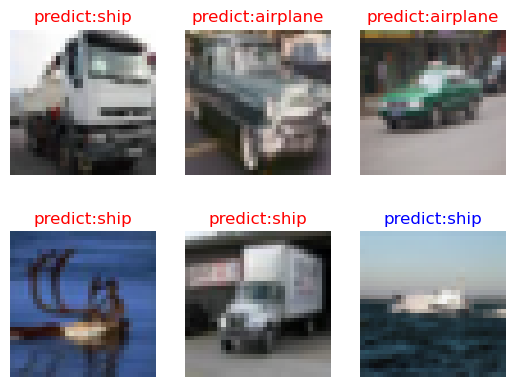

In [78]:
import matplotlib.pyplot as plt


def visualize_model(best_ckpt_path, dataset_val):
    num_class = 10  # 对狼和狗图像进行二分类
    net = resnet50(num_class)
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)
    # 加载验证集的数据进行验证
    data = next(dataset_val.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    # labels = data["label"].asnumpy().argmax(axis=1)
    # 预测图像类别
    output = model.predict(ms.Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)
    # print(pred)

    # 图像分类
    classes = []

    with open(data_dir+"/batches.meta.txt", "r") as f:
        for line in f:
            line = line.rstrip()
            if line != '':
                classes.append(line)

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i+1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

# 使用测试数据集进行验证
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)